# Test Segment Anything Model (SAM) server Docker images

In this notebook example, we will test the SAM server Docker images that we built.
To test them, we launch OpenVINO™ Model Server or NVIDIA Triton™ Inference Server instances and make a client to use them.

## Prepare inference

In this section, we prepare an input image, point prompt, and util functions for testing the model server instances.

In [ ]:
!pip install numpy matplotlib opencv-python-headless

In [2]:
# Copyright (C) 2023 Intel Corporation
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the Apache License 2.0
# Some source codes are borrowed from https://github.com/facebookresearch/segment-anything

import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Tuple
from copy import deepcopy


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))


def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
    """
    Compute the output size given input size and target long side length.
    """
    scale = long_side_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)


def apply_coords(
    coords: np.ndarray, original_size: Tuple[int, ...], target_length: int
) -> np.ndarray:
    """
    Expects a numpy array of length 2 in the final dimension. Requires the
    original image size in (H, W) format.
    """
    old_h, old_w = original_size
    new_h, new_w = get_preprocess_shape(original_size[0], original_size[1], target_length)
    coords = deepcopy(coords).astype(float)
    coords[..., 0] = coords[..., 0] * (new_w / old_w)
    coords[..., 1] = coords[..., 1] * (new_h / old_h)
    return coords


def apply_image(image: np.ndarray, target_length: int) -> np.ndarray:
    """
    Expects a numpy array with shape HxWxC in uint8 format.
    """
    target_size = get_preprocess_shape(image.shape[0], image.shape[1], target_length)
    # Convert (H, W) to (W, H) for OpenCV
    return cv2.resize(image, tuple(reversed(target_size)))

In [3]:
input_point = np.array([[380, 300]])
input_label = np.array([1])

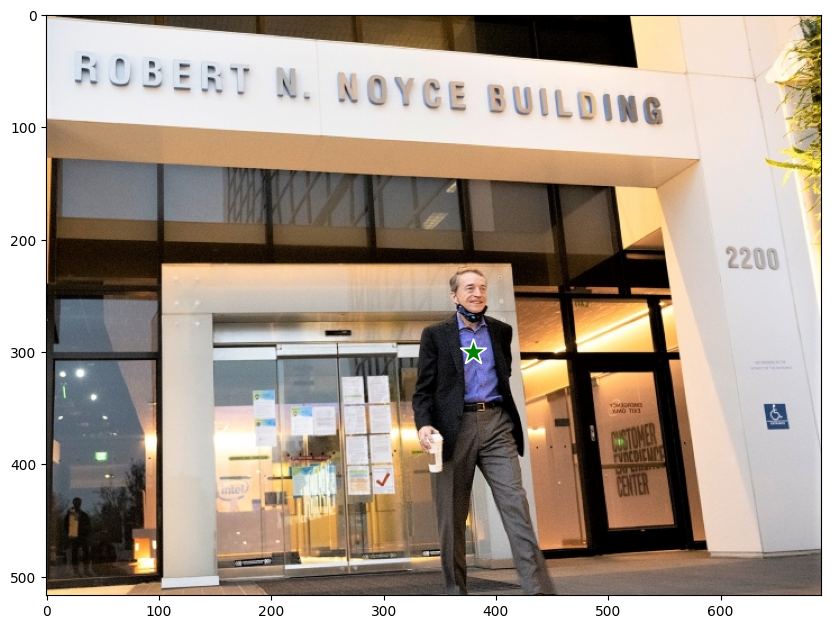

In [4]:
image = cv2.imread("images/intel_rnb.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

In [5]:
target_length = 1024
mask_threshold = 0.0

In [6]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = apply_coords(onnx_coord, image.shape[:2], target_length).astype(np.float32)

In [7]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

In [8]:
img = apply_image(image, 1024)
img = np.expand_dims(np.transpose(img, (2, 0, 1)), 0).astype(np.float32)

In [9]:
img.shape

(1, 3, 767, 1024)

## Test OpenVINO™ Model Server instance

To test below example, you need to launch the model server instance first. Please see [README.md](README.md) for more details.

In [ ]:
!pip install ovmsclient

In [11]:
from ovmsclient import make_grpc_client

client = make_grpc_client("localhost:9000")

image_embeddings = client.predict({"img": img}, "sam_encoder")

decoder_inputs = {
    "image_embeddings": image_embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32),
}

output = client.predict(decoder_inputs, "sam_decoder")

masks, _, low_res_logits = output["masks"], output["iou_predictions"], output["low_res_masks"]
masks = masks > mask_threshold

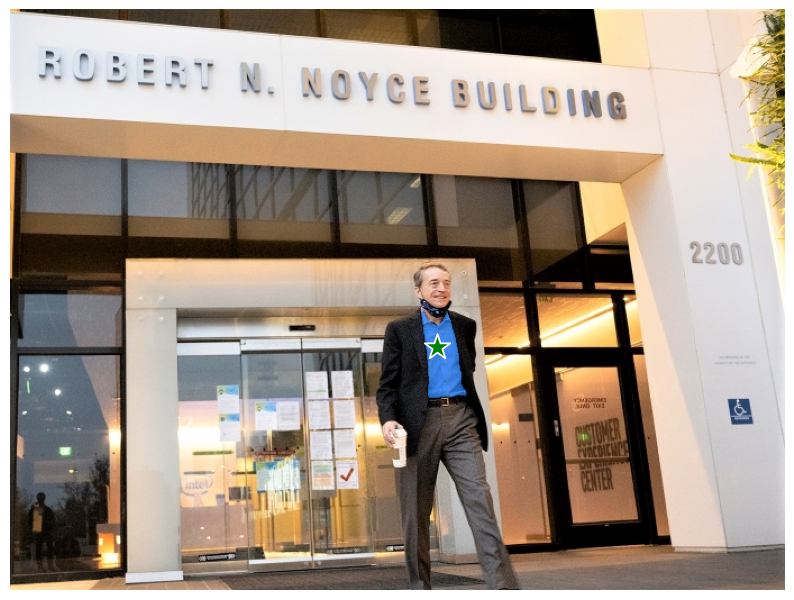

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()

## Test NVIDIA Triton™ Inference Server instance

To test below example, you need to launch the model server instance first. Please see [README.md](README.md) for more details.

In [ ]:
!pip install tritonclient[grpc]

In [14]:
import tritonclient.grpc as grpcclient

client = grpcclient.InferenceServerClient(url="localhost:8001")

/home/vinnamki/miniconda3/envs/datumaro/lib/python3.9/site-packages/tritonclient/grpc/__init__.py:54: UserWarning: Imported version of grpc is 1.50.0. There is a memory leak in certain Python GRPC versions (1.43.0 to be specific). Please use versions <1.43.0 or >=1.51.1 to avoid leaks (see https://github.com/grpc/grpc/issues/28513).
  warnings.warn(


In [15]:
def create_numpy_input(np_array: np.ndarray, name: str, shape: list, datatype: str):
    inp = grpcclient.InferInput(name=name, shape=shape, datatype=datatype)
    inp.set_data_from_numpy(np_array)
    return inp


results = client.infer(
    model_name="sam_encoder",
    inputs=[create_numpy_input(img, "img", img.shape, "FP32")],
    outputs=[
        grpcclient.InferRequestedOutput("image_embeddings", class_count=0),
    ],
)
image_embedding = results.as_numpy("image_embeddings")

In [16]:
results = client.infer(
    model_name="sam_decoder",
    inputs=[
        create_numpy_input(image_embedding, "image_embeddings", image_embedding.shape, "FP32"),
        create_numpy_input(onnx_coord, "point_coords", onnx_coord.shape, "FP32"),
        create_numpy_input(onnx_label, "point_labels", onnx_label.shape, "FP32"),
        create_numpy_input(onnx_mask_input, "mask_input", onnx_mask_input.shape, "FP32"),
        create_numpy_input(
            onnx_has_mask_input, "has_mask_input", onnx_has_mask_input.shape, "FP32"
        ),
        create_numpy_input(
            np.array(image.shape[:2], dtype=np.float32), "orig_im_size", (2,), "FP32"
        ),
    ],
    outputs=[
        grpcclient.InferRequestedOutput("masks", class_count=0),
        grpcclient.InferRequestedOutput("iou_predictions", class_count=0),
        grpcclient.InferRequestedOutput("low_res_masks", class_count=0),
    ],
)
masks, _, low_res_logits = (
    results.as_numpy("masks"),
    results.as_numpy("iou_predictions"),
    results.as_numpy("low_res_masks"),
)
masks = masks > mask_threshold

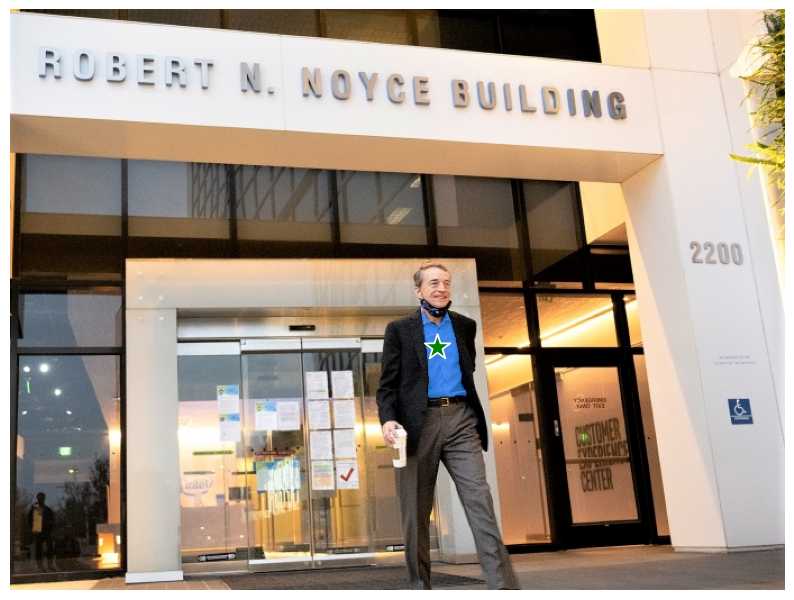

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()